In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import font_manager

%matplotlib inline

# 日本語フォントの設定
font_path = 'C:/Windows/Fonts/msgothic.ttc'  # MS Gothicフォントのパス
font_manager.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'MS Gothic'

In [4]:
#モデルの学習

import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from shapely.wkt import loads
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold, train_test_split
import shap
import optuna
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from optuna.samplers import TPESampler

class Apart_train_model:
    def __init__(self, 
                 teacher_data_path,
                 target_usage,
                 model_output_path
                 ):
        self.teacher_data_path = teacher_data_path
        self.target_usage = target_usage
        self.X_train = None
        self.Y_train = None
        self.X_test = None
        self.Y_test = None
        self.teacher_data = None
        self.y_train_fold = None
        self.X_resampled, y_resampled  = None, None
        self.model_output_path = model_output_path

    def load_data(self):
        self.teacher_data = gpd.read_parquet(self.teacher_data_path)
    
    def target_variable(self):
        # 目的変数の追加
        self.teacher_data['target'] = self.teacher_data['usage'] == self.target_usage
        self.teacher_data['target'] = self.teacher_data['target'].astype(int)
    
    def clean_data(self):
        need_col = ['年少人口', '生産年齢人口', '老年人口', 
                    '出生時から', '1年未満', '1年以上5年未満', '5年以上10年未満',
                    '10年以上20年未満', '20年以上', '居住期間「不詳」', '01_500万円未満', '07_500～1000万円未満',
                    '一戸建', '長屋建', '共同住宅', 
                    'area', 'rectangularity', 'convexity', 'moment_of_inertia', 'num_corners', 
                    'anisotropy', 'longest_axis', 'elongation', 'orientation',
                    'type_堅ろう建物', 'type_堅ろう無壁舎', 'type_普通建物', 'type_普通無壁舎', 
                    'target']
        
        self.teacher_data = self.teacher_data[need_col]

    def prepare_train(self):
        #教師データを説明変数と目的変数に分ける
        df = self.teacher_data.copy()
        df_x = df.drop(columns='target')
        df_y = df["target"]

        # ====== ここから追加・変更 =======
        # 全教師データに対してアンダーサンプリングを適用
        print("--- アンダーサンプリング前のクラス分布 ---")
        print(df_y.value_counts())
        # 少数派クラス（1）のサンプル数を取得
        num_minority_samples_full = df_y.value_counts().get(1, 0)
        # 多数派クラス（0）の目標サンプル数を計算  
        how_many_times = 1  # 少数派の1倍
        num_majority_samples_full = num_minority_samples_full * how_many_times
        # 実際の多数派クラスの数が目標サンプル数より少ない場合は、実際の数に合わせる
        actual_majority_samples_full = df_y.value_counts().get(0, 0)
        num_majority_samples_full = min(num_majority_samples_full, actual_majority_samples_full)
        # サンプリング戦略を定義
        sampling_strategy_full = {0: num_majority_samples_full, 1: num_minority_samples_full}
        # RandomUnderSamplerを適用
        # random_state を設定して再現性を確保
        rus_full = RandomUnderSampler(sampling_strategy=sampling_strategy_full, random_state=42)
        self.X_resampled, self.y_resampled = rus_full.fit_resample(df_x, df_y)
        print("\n--- アンダーサンプリング後のクラス分布 ---")
        print(self.y_resampled.value_counts())
        # ====== ここまで追加・変更 =======
        
        self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(self.X_resampled, self.y_resampled, test_size=0.3, random_state=42)
        
    def objective(self, trial):
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'eta': trial.suggest_loguniform('eta', 0.01, 0.5),
            'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
            'seed': 42,
        }

        kf = KFold(n_splits=3, shuffle=True, random_state=42)
        f1_list = []
        for fold, (train_index, val_index) in enumerate(kf.split(self.X_train)):
            X_train_fold, X_val_fold = self.X_train.iloc[train_index], self.X_train.iloc[val_index]
            y_train_fold, y_val_fold = self.Y_train.iloc[train_index], self.Y_train.iloc[val_index]

            # DMatrix形式に変換 (アンダーサンプリング後のデータを使用)
            dtrain = xgb.DMatrix(X_train_fold, label=y_train_fold)
            dval = xgb.DMatrix(X_val_fold, label=y_val_fold)

            model = xgb.train(params, dtrain, num_boost_round=10, evals=[(dtrain, 'train'), (dval, 'eval')],
                            early_stopping_rounds=10, verbose_eval=False)

            preds_proba = model.predict(dval)
            preds = (preds_proba >= 0.5).astype(int)

            f1 = f1_score(y_val_fold, preds)
            f1_list.append(f1)

        return np.mean(f1_list)

    # モデルを最適化する関数
    def optimize_xgb_with_optuna(self):
        # 乱数を固定したサンプラーを作成
        sampler = TPESampler(seed=42) 
        # studyを作成する際に、このサンプラーを渡す
        study = optuna.create_study(direction='maximize', sampler=sampler)
        study.optimize(lambda trial: self.objective(trial), n_trials=50)
        best_params = study.best_trial.params
        
        # 最適なハイパーパラメータを表示
        print('Best trial: ', best_params)

        # 最適なハイパーパラメータで最終モデルをトレーニング
        models = []

        # 各foldの予測精度を格納するリスト
        accuracy_list = []
        precision_list = []
        recall_list = []
        f1_list = []

        # feature importancesを格納するDataFrame
        feature_importances_df = pd.DataFrame()

        # 追加: 最も高いF1スコアとそのモデルを追跡するための変数
        best_f1_score_overall = -1.0 # F1スコアの初期値は-1.0 (最小値)
        best_f1_model = None # 最も良いモデルを格納する変数

        #交差検証
        kf = KFold(n_splits=3, shuffle=True, random_state=42)
        for fold, (train_index, val_index) in enumerate(kf.split(self.X_train)):
            x_train_fold, x_val_fold = self.X_train.iloc[train_index], self.X_train.iloc[val_index]
            y_train_fold, y_val_fold = self.Y_train.iloc[train_index], self.Y_train.iloc[val_index]


            self.y_train_fold = y_train_fold

            # DMatrix形式に変換 (アンダーサンプリング後のデータを使用)
            dtrain = xgb.DMatrix(x_train_fold, label=y_train_fold) # 変更: X_train_fold, y_train_fold を使用
            dval = xgb.DMatrix(x_val_fold, label=y_val_fold)
            dtest = xgb.DMatrix(self.X_test, label=self.Y_test) 

            # モデルを学習
            model = xgb.train(best_params, dtrain, num_boost_round=10, evals=[(dtrain, 'train'), (dval, 'eval')],
                              early_stopping_rounds=10, verbose_eval=False)

            # 検証データ(validation data)で最適な閾値を探す
            val_preds_proba = model.predict(dval)
            best_threshold = 0
            best_f1 = 0
            # 0.01から0.99まで0.01刻みで閾値を試す
            for threshold in np.arange(0.01, 1.0, 0.01):
                val_preds = (val_preds_proba >= threshold).astype(int)
                f1 = f1_score(y_val_fold, val_preds)
                if f1 > best_f1:
                    best_f1 = f1
                    best_threshold = threshold
            
            print(f"Fold {fold + 1} - Found Best Threshold: {best_threshold:.2f} (with F1 score: {best_f1:.4f} on validation set)")
            
            # feature importancesを取得
            feature_importances = pd.DataFrame()
            feature_importances["feature"] = self.X_train.columns
            # XGBoostの特徴量重要度を取得し、存在しない特徴量の重要度を0に設定
            importance_dict = model.get_score(importance_type='weight')
            feature_importances["importance"] = feature_importances["feature"].map(importance_dict).fillna(0)
            feature_importances["fold"] = fold
            feature_importances_df = pd.concat([feature_importances_df, feature_importances], axis=0)

            preds_proba = model.predict(dtest)

            # 予測結果を取得（さきほど見つけた最適な閾値を使用）
            preds = (preds_proba >= best_threshold).astype(int)

            print("=" * 50)
            print(f"Start of Fold {fold + 1}")

            accuracy = accuracy_score(self.Y_test, preds)
            precision = precision_score(self.Y_test, preds)
            recall = recall_score(self.Y_test, preds)
            f1 = f1_score(self.Y_test, preds)

            # 追加: 最も高いF1スコアを持つモデルを更新
            if f1 > best_f1_score_overall:
                best_f1_score_overall = f1
                best_f1_model = model # モデルオブジェクトを保存
                print(f"  New best F1 score found: {best_f1_score_overall:.4f} in Fold {fold + 1}")

            # 混同行列を取得して先に表示（数値）
            cm = confusion_matrix(self.Y_test, preds)
            cm_float = cm.astype(float)
            print(f"Fold {fold + 1} - Confusion Matrix (Precise Values):\n{cm_float}")
            
            # 表示
            print("\n===== 最適化されたハイパーパラメータ =====")
            for key, val in best_params.items():
                print(f"  {key}: {val}")

            print("\n===== 最適な閾値 =====")
            print(f"  Best Threshold: {best_threshold:.2f}")
            
            # スコアも表示
            print("\n===== スコア =====")
            print(f"Fold {fold + 1} - Test Set Results:")
            print(f"Accuracy: {accuracy:.3f}")
            print(f"Precision: {precision:.3f}")
            print(f"Recall: {recall:.3f}")
            print(f"F1 Score: {f1:.3f}")
            print("-" * 40)

            # プロットは最後に
            plt.figure(figsize=(6, 5))
            sns.heatmap(cm_float, annot=True, fmt=".10g", cmap='Blues')
            plt.title(f"Confusion Matrix - Fold {fold + 1}")
            plt.xlabel("Predicted Label")
            plt.ylabel("True Label")
            plt.show()
            
            print(f"End of Fold {fold + 1}")
            print("=" * 50)
            
            models.append(model)

        # 追加: 交差検証ループ終了後に、最もF1スコアが高かったモデルを保存
        if best_f1_model is not None:
            best_f1_model.save_model(self.model_output_path)
            print(f"modelのセーブ完了")
        else:
            print("\nNo model was saved (best_f1_model is None).")

        mean_feature_importances = feature_importances_df.groupby("feature")["importance"].mean().reset_index()
        mean_feature_importances = mean_feature_importances.sort_values(by="importance", ascending=False)
        
        plt.figure(figsize=(16, 10))
        mean_feature_importances_20 = mean_feature_importances.head(20)
        sns.barplot(x="importance", y="feature", data=mean_feature_importances_20, palette="viridis")
        plt.xlabel("重要度", fontsize=20)
        plt.ylabel("特徴量", fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.title("Mean Feature Importances (Top 20)", fontsize=22)
        plt.grid(True, linestyle='--', zorder=0)
        plt.tight_layout()
        plt.show()
        print('次のfoldに移行中')
        
        if models:
            explainer = shap.TreeExplainer(models[0])
            shap_values = explainer.shap_values(self.X_test)
            shap_df = pd.DataFrame(shap_values, columns=self.X_test.columns)
            top_10_features = shap_df.abs().mean().sort_values(ascending=False).head(10).index.tolist()
            shap.summary_plot(shap_df[top_10_features].values, self.X_test[top_10_features], plot_type='dot', show=False)
        else:
            print("No models were trained for SHAP value calculation.")

        print('次のfoldに移行中')

    def run(self):
        self.load_data()
        self.target_variable()
        self.clean_data()
        self.prepare_train()
        self.optimize_xgb_with_optuna()

[I 2025-07-15 10:43:09,001] A new study created in memory with name: no-name-630a79a6-38cc-4cd0-909d-867a8bd9b01a
C:\Users\0141s\AppData\Local\Temp\ipykernel_39504\3126682886.py:92: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 0.01, 0.5),
C:\Users\0141s\AppData\Local\Temp\ipykernel_39504\3126682886.py:93: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\0141s\AppData\Local\Temp\ipykernel_39504\3126682886.py:94: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

--- アンダーサンプリング前のクラス分布 ---
target
0    147319
1      4367
Name: count, dtype: int64

--- アンダーサンプリング後のクラス分布 ---
target
0    4367
1    4367
Name: count, dtype: int64


C:\Users\0141s\AppData\Local\Temp\ipykernel_39504\3126682886.py:92: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 0.01, 0.5),
C:\Users\0141s\AppData\Local\Temp\ipykernel_39504\3126682886.py:93: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\0141s\AppData\Local\Temp\ipykernel_39504\3126682886.py:94: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
[I 2025-07-15 10:43:09,232] 

Best trial:  {'max_depth': 6, 'eta': 0.026517217595242188, 'subsample': 0.7521485674536212, 'colsample_bytree': 0.6684204144342916}
Fold 1 - Found Best Threshold: 0.47 (with F1 score: 0.8180 on validation set)
Start of Fold 1
  New best F1 score found: 0.8077 in Fold 1
Fold 1 - Confusion Matrix (Precise Values):
[[ 814.  508.]
 [  75. 1224.]]

===== 最適化されたハイパーパラメータ =====
  max_depth: 6
  eta: 0.026517217595242188
  subsample: 0.7521485674536212
  colsample_bytree: 0.6684204144342916

===== 最適な閾値 =====
  Best Threshold: 0.47

===== スコア =====
Fold 1 - Test Set Results:
Accuracy: 0.778
Precision: 0.707
Recall: 0.942
F1 Score: 0.808
----------------------------------------


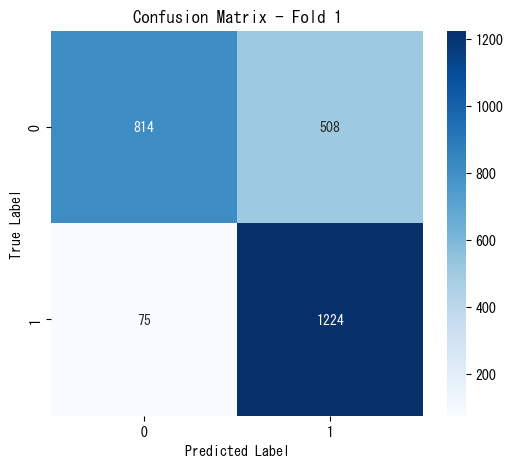

End of Fold 1
Fold 2 - Found Best Threshold: 0.49 (with F1 score: 0.8245 on validation set)
Start of Fold 2
  New best F1 score found: 0.8236 in Fold 2
Fold 2 - Confusion Matrix (Precise Values):
[[ 947.  375.]
 [ 127. 1172.]]

===== 最適化されたハイパーパラメータ =====
  max_depth: 6
  eta: 0.026517217595242188
  subsample: 0.7521485674536212
  colsample_bytree: 0.6684204144342916

===== 最適な閾値 =====
  Best Threshold: 0.49

===== スコア =====
Fold 2 - Test Set Results:
Accuracy: 0.808
Precision: 0.758
Recall: 0.902
F1 Score: 0.824
----------------------------------------


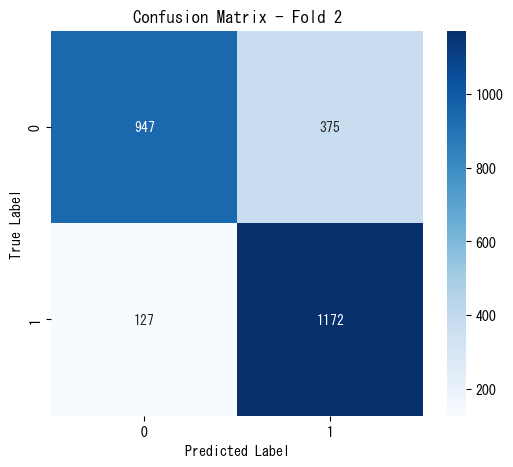

End of Fold 2
Fold 3 - Found Best Threshold: 0.49 (with F1 score: 0.8291 on validation set)
Start of Fold 3
Fold 3 - Confusion Matrix (Precise Values):
[[ 947.  375.]
 [ 140. 1159.]]

===== 最適化されたハイパーパラメータ =====
  max_depth: 6
  eta: 0.026517217595242188
  subsample: 0.7521485674536212
  colsample_bytree: 0.6684204144342916

===== 最適な閾値 =====
  Best Threshold: 0.49

===== スコア =====
Fold 3 - Test Set Results:
Accuracy: 0.804
Precision: 0.756
Recall: 0.892
F1 Score: 0.818
----------------------------------------


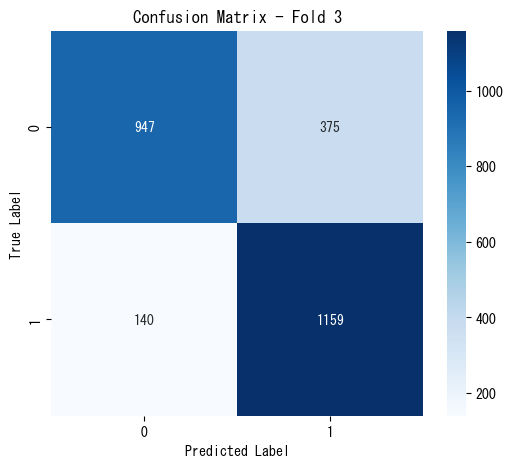

End of Fold 3
modelのセーブ完了


C:\Users\0141s\AppData\Local\Temp\ipykernel_39504\3126682886.py:254: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=mean_feature_importances_20, palette="viridis")


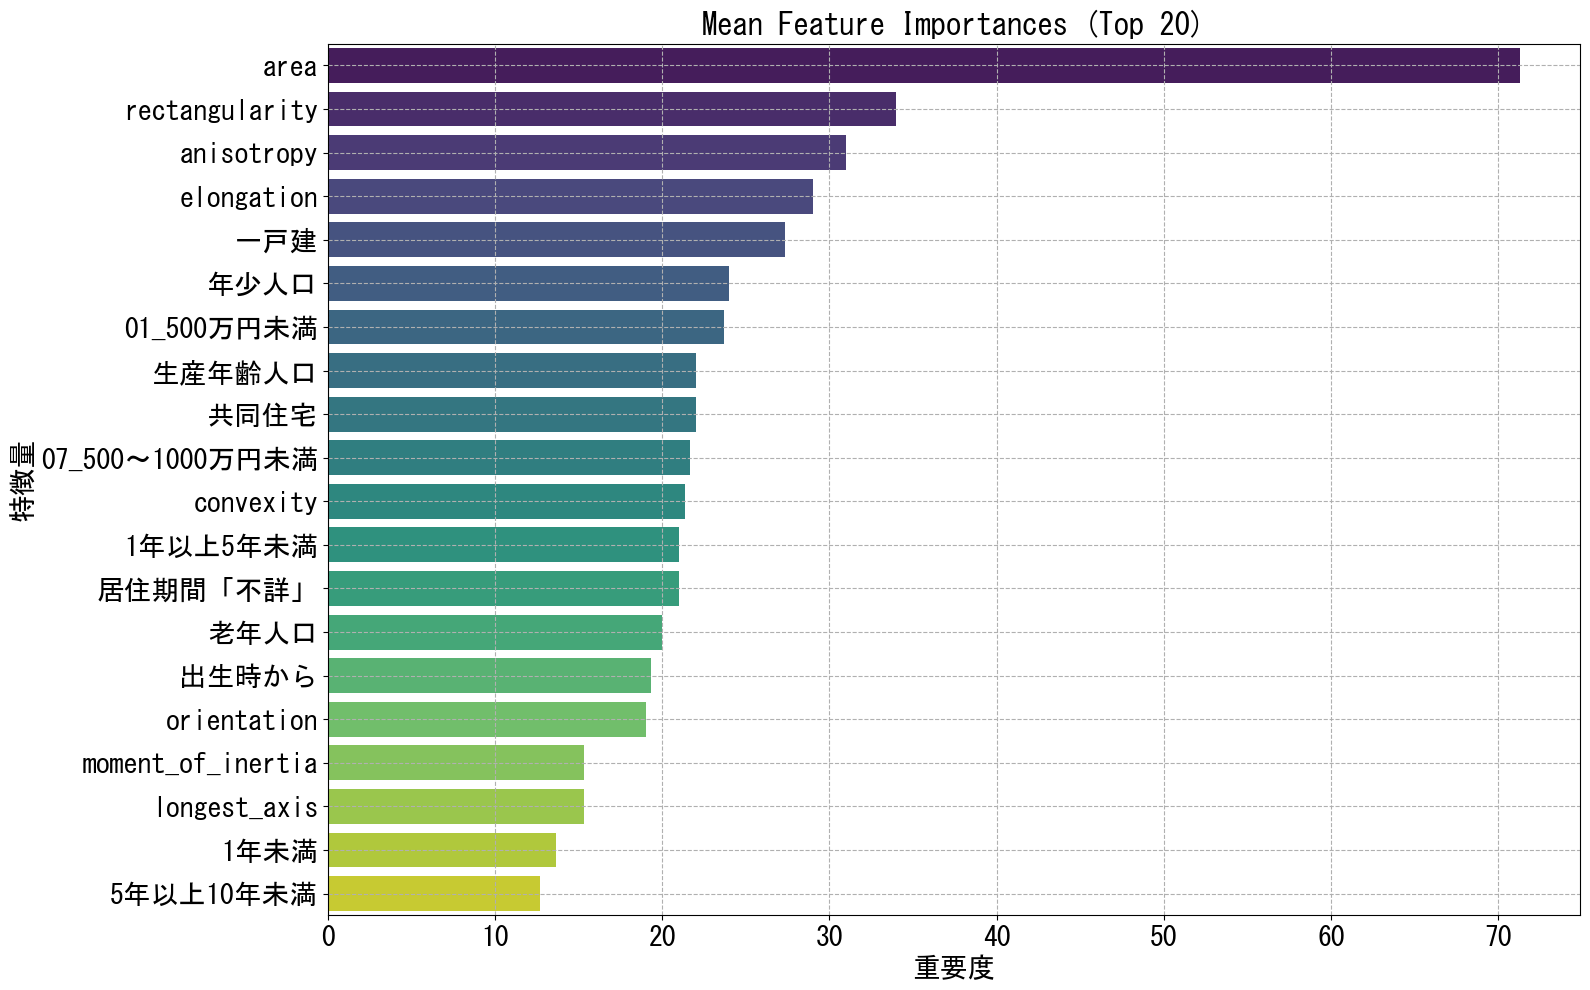

次のfoldに移行中
次のfoldに移行中


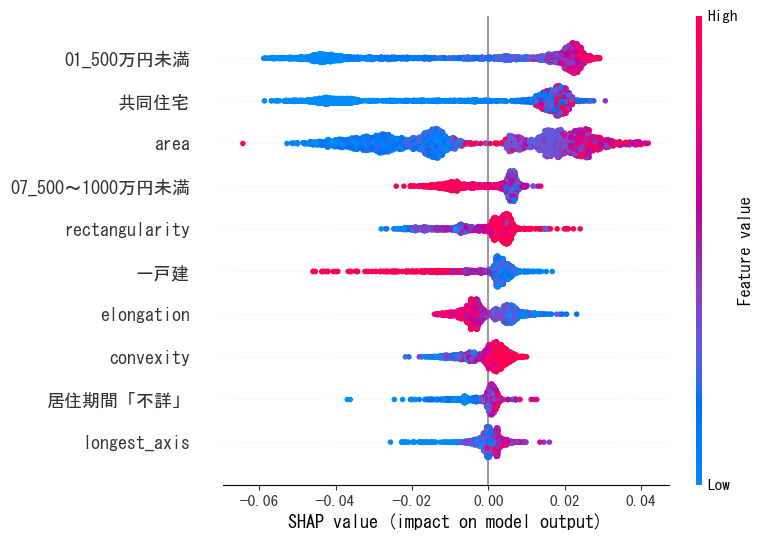

In [5]:
# 実行ファイル
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

if __name__ == "__main__":
    #教師データのパス
    teacher_data = "G:/マイドライブ/akiyamalab/オープン住宅地図/dev_2025/train/feature_engineering/apart/15202_apart.parquet"
    target_usage = '412'
    model_output_path = "G:/マイドライブ/akiyamalab/オープン住宅地図/dev_2025/train/train_model/15202_apart.json"


    train_model = Apart_train_model(teacher_data,
                              target_usage,
                              model_output_path
                             )

    train_model.run()

In [101]:
df_x = train_model.X_resampled
df_y = train_model.y_resampled

In [102]:
df = df_x.join(df_y, how='inner')

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17468 entries, 144365 to 52628
Data columns (total 39 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   年少人口               17363 non-null  float64
 1   生産年齢人口             17363 non-null  float64
 2   老年人口               17363 non-null  float64
 3   出生時から              17363 non-null  float64
 4   1年未満               17363 non-null  float64
 5   1年以上5年未満           17363 non-null  float64
 6   5年以上10年未満          17363 non-null  float64
 7   10年以上20年未満         17363 non-null  float64
 8   20年以上              17363 non-null  float64
 9   居住期間「不詳」           17363 non-null  float64
 10  01_500万円未満         17363 non-null  float64
 11  07_500～1000万円未満    17363 non-null  float64
 12  一戸建                17363 non-null  float64
 13  長屋建                17363 non-null  float64
 14  共同住宅               17363 non-null  float64
 15  1_amenity          1315 non-null   float64
 16  1_shop             131

<Axes: xlabel='usage'>

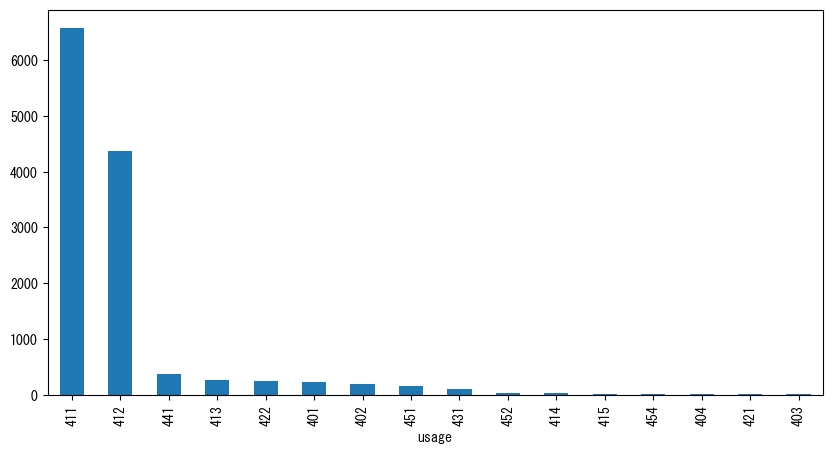

In [92]:
df['usage'].value_counts().plot(kind='bar', figsize=(10, 5))

In [94]:
teacher_data_path = "G:/マイドライブ/akiyamalab/オープン住宅地図/dev_2025/train/feature_engineering/apart/15202_apart.parquet"

teacher_data = gpd.read_parquet(teacher_data_path)

In [97]:
teacher_data['convexity']

0         1.000000
1         0.831955
2         1.000000
3         0.976451
4         1.000000
            ...   
151681    0.999969
151682    1.000000
151683    1.000000
151684    1.000000
151685    1.000000
Name: convexity, Length: 151686, dtype: float64

In [18]:
teacher_data['usage'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 151686 entries, 0 to 151685
Series name: usage
Non-Null Count  Dtype 
--------------  ----- 
96495 non-null  object
dtypes: object(1)
memory usage: 1.2+ MB


In [37]:
train_model.teacher_data['target'].value_counts()

target
0    147319
1      4367
Name: count, dtype: int64

In [30]:
train_model.Y_test.value_counts()

target
0    44199
1     1307
Name: count, dtype: int64

In [17]:
test = train_model.teacher_data

In [24]:
test['target'].value_counts()

target
0    73418
1     4351
Name: count, dtype: int64